# Connect to dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2 as cv
import random

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
def random_load_image_from_directory(directory, num_images=10):
  images = []
  for filename in os.listdir(directory):
    img = cv.imread(os.path.join(directory, filename))
    images.append(img)

  return random.sample(images, min(num_images, len(images)))

In [5]:
random_bacterial_blight = random_load_image_from_directory("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Bacterial_Leaf_Blight")
bacterial_blight = load_images_from_folder("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Bacterial_Leaf_Blight")

# Image Preprocessing

In [6]:
import matplotlib.pyplot as plt

## Background Remover Binary

In [ ]:
def background_remover(image):
  image = cv.imread(image)
  hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

  saturation = hsv_image[:, :, 1]
  _, binary_mask = cv.threshold(saturation, 85, 255, cv.THRESH_BINARY)
  masked_image = cv.bitwise_and(image, image, mask=binary_mask)
  return masked_image

### Validation BG Remover

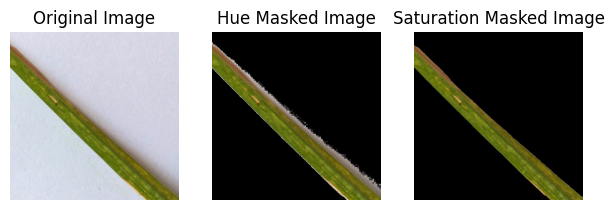

(-0.5, 1628.5, 1628.5, -0.5)

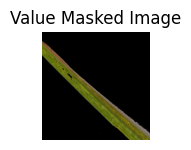

In [41]:
BG_remove_image = cv.imread("/content/drive/MyDrive/Research Leaf/ASHIIQ/Train/ASHIQ_Train_Blast/IMG_20190419_164227.jpg")

hsv_image = cv.cvtColor(BG_remove_image, cv.COLOR_BGR2HSV)

hue = hsv_image[:, :, 0]
saturation = hsv_image[:, :, 1]
value = hsv_image[:, :, 2]

_, hue_binary_mask = cv.threshold(hue, 50, 255, cv.THRESH_BINARY_INV)
_, saturation_binary_mask = cv.threshold(saturation, 100, 255, cv.THRESH_BINARY)
_, value_binary_mask = cv.threshold(value, 150, 255, cv.THRESH_BINARY_INV)

hue_masked_image = cv.bitwise_and(BG_remove_image, BG_remove_image, mask=hue_binary_mask)
saturation_masked_image = cv.bitwise_and(BG_remove_image, BG_remove_image, mask=saturation_binary_mask)
value_masked_image = cv.bitwise_and(BG_remove_image, BG_remove_image, mask=value_binary_mask)

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(cv.cvtColor(BG_remove_image, cv.COLOR_BGR2RGB))

plt.subplot(1, 4, 2)
plt.title("Hue Masked Image")
plt.imshow(cv.cvtColor(hue_masked_image, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Saturation Masked Image")
plt.imshow(cv.cvtColor(saturation_masked_image, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

plt.subplot(1, 4, 4)
plt.title("Value Masked Image")
plt.imshow(cv.cvtColor(value_masked_image, cv.COLOR_BGR2RGB))
plt.axis("off")

# Calculate optimal cluster

In [37]:
from sklearn.cluster import KMeans

## Elbow Within Cluster Sum of Square Method

### EW for 1 image

In [49]:
def calculate_wcss(image, max_k=10):
    wcss = []
    pixel_values = image.reshape((-1, 3))
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        wcss.append(kmeans.inertia_)
    return wcss

In [48]:
wcss = calculate_wcss(test_image, max_k=10)

NameError: name 'test_image' is not defined

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

### EW for multi image

In [ ]:
def calculate_multi_image_wcss(images, max_k=10):
    wcss = []
    pixel_values = np.vstack([img.reshape((-1, 3)) for img in images])
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        wcss.append(kmeans.inertia_)
    return wcss

In [ ]:
wcss = calculate_multi_image_wcss(random_bacterial_blight, max_k=10)


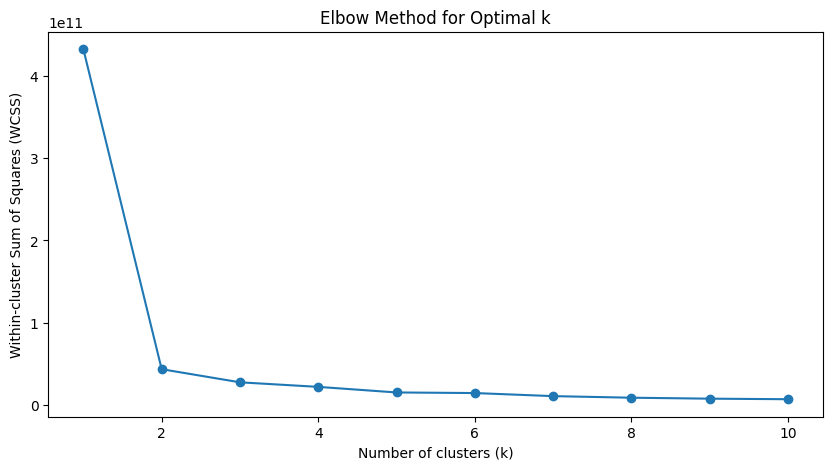

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()

## Gap Statistic Method

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
def find_optimal_k(gaps, s_k):
    for k in range(1, len(gaps)):
        if gaps[k-1] >= gaps[k] - s_k[k]:
            return k
    return len(gaps)

### GS Single Image

In [38]:
def calculate_gap_statistic(image, max_k=10, n_refs=10):
    pixel_values = image.reshape((-1, 3))

    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)

        disp = np.sum(np.min(pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))

        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            random_reference = np.random.uniform(
                low=pixel_values.min(axis=0),
                high=pixel_values.max(axis=0),
                size=pixel_values.shape
            )
            kmeans.fit(random_reference)
            ref_disp = np.sum(np.min(pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))
            ref_disps[i] = ref_disp

        log_ref_disp = np.log(ref_disps)
        gaps[k-1] = np.mean(log_ref_disp) - np.log(disp)
        s_k[k-1] = np.sqrt(np.sum((log_ref_disp - np.mean(log_ref_disp))**2) / n_refs)

    return gaps, s_k

In [42]:
gaps, s_k = calculate_gap_statistic(BG_remove_image, max_k=8, n_refs=8)

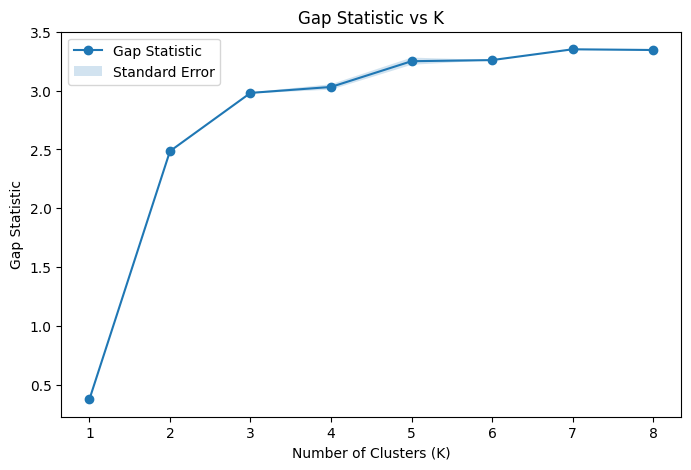

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(gaps) + 1), gaps, marker='o', label='Gap Statistic')
plt.fill_between(range(1, len(gaps) + 1), gaps - s_k, gaps + s_k, alpha=0.2, label='Standard Error')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs K')
plt.legend()
plt.show()

In [46]:
optimal_k = find_optimal_k(gaps, s_k)
print(f"The optimal number of clusters (K) is: {optimal_k}")

The optimal number of clusters (K) is: 7
The optimal number of clusters (K Argmax) is: 7


### GS Multi Images

In [ ]:
def multi_calculate_gap_statistic(images, max_k=10, n_refs=10):
    pixel_values = np.vstack([img.reshape((-1, 3)) for img in images])
    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixel_values)
        disp = np.mean(
            np.min(
                pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean'), axis=1
            )
        )
        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            random_reference = np.random.random_sample(size=pixel_values.shape)
            kmeans.fit(random_reference)
            ref_disp = np.mean(
                np.min(
                    pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean'), axis=1
                )
            )
            ref_disps[i] = ref_disp
        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps[k - 1] = gap
        s_k[k - 1] = np.sqrt(
            np.mean((np.log(ref_disps) - np.log(np.mean(ref_disps)))**2)
        )

    return gaps, s_k

In [ ]:
gaps, s_k = calculate_gap_statistic(random_bacterial_blight, max_k=8)

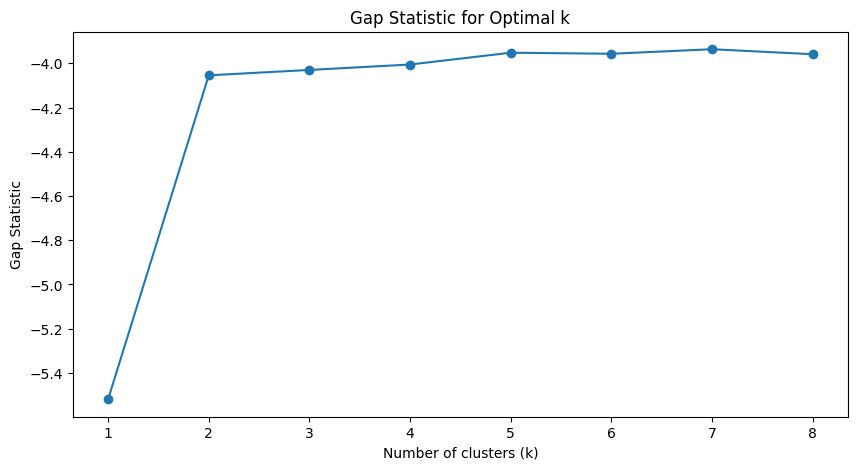

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(gaps) + 1), gaps, marker='o', label='Gap Statistic')

plt.errorbar(range(1, len(gaps) + 1), gaps, yerr=s_k, fmt='o', color='black', label='Standard Deviation')

optimal_k = np.argmax(gaps) + 1
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')

plt.title('Gap Statistic vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Gap Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimal_k = np.argmax(gaps) + 1
print(f'The optimal number of clusters is: {optimal_k}')

The optimal number of clusters is: 7


# K mean segmentation






In [7]:
import numpy as np

In [8]:
def k_mean_segmentation(disease, attempts=10, K=2):
  leaf_image = disease.reshape((-1,3))
  leaf_image = np.float32(leaf_image)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret, labels, centers = cv.kmeans(leaf_image, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

  centers = np.uint8(centers)
  segmented_image = centers[labels.flatten()]
  segmented_image = segmented_image.reshape((disease.shape))

  return segmented_image, labels, centers

In [9]:
def mask_filter(image, segmented_image, cluster, labels):
  mask = (labels.flatten() == cluster)
  filtered_image = np.zeros_like(segmented_image)
  filtered_image[mask.reshape(image.shape[:2])] = segmented_image[mask.reshape(image.shape[:2])]
  return filtered_image

In [20]:
test_K = 8
test_image = cv.imread("/content/drive/MyDrive/Research Leaf/ASHIIQ/Validate/ASHIQ_Validation_Healthy/IMG_20190419_144058.jpg")
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)
segmented_test_image, test_labels, test_center = k_mean_segmentation(test_image, K=test_K)

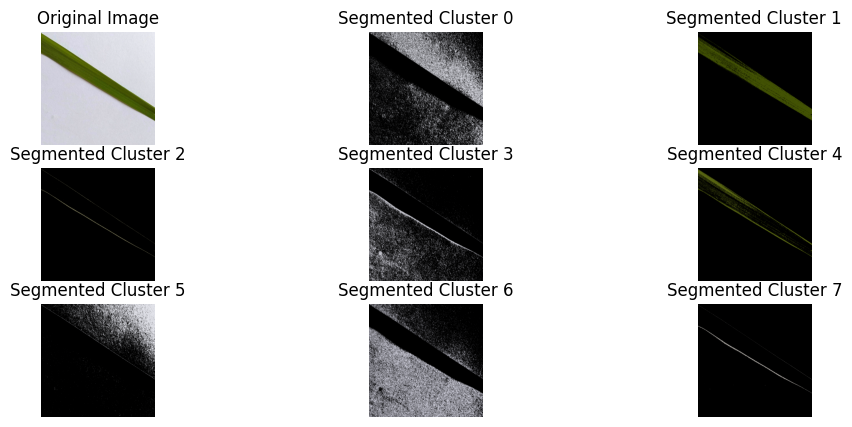

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(3, 3, 1)
plt.title("Original Image")
plt.imshow(test_image)
plt.axis("off")

for cluster in range(test_K):
  filtered_test_image = mask_filter(test_image, segmented_test_image, cluster, test_labels)

  plt.subplot(3, 3, cluster + 2)
  plt.title(f'Segmented Cluster {cluster}')
  plt.imshow(filtered_test_image)
  plt.axis("off")

plt.show()

# Post Clustering

(0.27320322312066947, 1.4206567602274813, 2.7593525535187617)


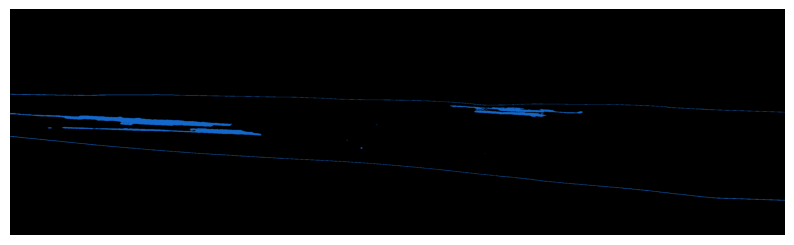

In [12]:
diseased_portion_image = mask_filter(test_image, segmented_test_image, 2, test_labels)
diseased_portion_image = cv.cvtColor(diseased_portion_image, cv.COLOR_RGB2HSV)
mean_hsv = cv.mean(diseased_portion_image)[:3]
print(mean_hsv)
plt.figure(figsize=(10, 5))
plt.imshow(diseased_portion_image)
plt.axis("off")
plt.show()

In [13]:
def normalize_hsv(hsv_value):
    hue, saturation, value = hsv_value
    hue_normalized = hue / 180.0
    saturation_normalized = saturation / 255.0
    value_normalized = value / 255.0

    return np.array([hue_normalized, saturation_normalized, value_normalized])

In [14]:
def calculate_hsv_similarity(hsv1, hsv2):
    hsv1 = np.array(hsv1)
    hsv2 = np.array(hsv2)
    return np.linalg.norm(hsv1 - hsv2)

In [15]:
mean_hsv

(0.27320322312066947, 1.4206567602274813, 2.7593525535187617)

(28.701904586876328, 2.453154238194558, 55.44128578319701)
Cluster 0 mengandung penyakit dengan mean HSV (28.701904586876328, 2.453154238194558, 55.44128578319701)
(3.896371606322165, 26.300508342674615, 8.983301203464992)
Cluster 1 mengandung penyakit dengan mean HSV (3.896371606322165, 26.300508342674615, 8.983301203464992)
(0.17556183019913393, 0.45516030051627315, 0.7997816709071657)
Cluster 2 mengandung penyakit dengan mean HSV (0.17556183019913393, 0.45516030051627315, 0.7997816709071657)
(14.156083234001413, 1.2976409631167962, 25.00908038006916)
(1.493040673965221, 8.958244043791327, 4.308488802013924)
(15.03691630499733, 1.166657299525655, 30.333089787667028)
(41.028601731806226, 5.128575216475778, 75.90291320384152)
(0.13243804153424807, 0.10127614940854263, 1.332170888373907)
Cluster 7 mengandung penyakit dengan mean HSV (0.13243804153424807, 0.10127614940854263, 1.332170888373907)
Cluster penyakit terbaik ditemukan: 7


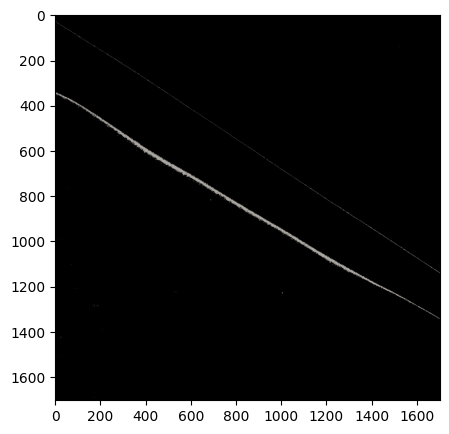

In [22]:
reference_hsv = normalize_hsv(mean_hsv)
tolerance = 10
disease_cluster = None
best_match_score = float('inf')

for cluster_idx in range(test_K):
    cluster_pixels = mask_filter(test_image, segmented_test_image, cluster_idx, test_labels)
    cluster_pixels_hsv = cv.cvtColor(cluster_pixels, cv.COLOR_RGB2HSV)
    mean_hsv_cluster = cv.mean(cluster_pixels_hsv)[:3]

    print(mean_hsv_cluster)

    score = calculate_hsv_similarity(normalize_hsv(mean_hsv_cluster), reference_hsv)

    if score < best_match_score:
        best_match_score = score
        disease_cluster = cluster_idx
        print(f"Cluster {cluster_idx} mengandung penyakit dengan mean HSV {mean_hsv_cluster}")

if disease_cluster is not None:
    print(f"Cluster penyakit terbaik ditemukan: {disease_cluster}")
    plt.figure(figsize=(10, 5))
    plt.imshow(mask_filter(test_image, segmented_test_image, disease_cluster, test_labels))
else:
    print("Cluster penyakit tidak ditemukan")